# DAT159 Assignment 2: Predicting Taxi Trip Duration in NYC
Submitted November 14th, 2018 by Laura Mann for Høgskulen på Vestlandet

# 1. Looking at the problem

I'm going to be looking at a dataset containing data about taxi trips in NYC, with the end goal of predicting the length of a taxi ride in NYC. The dataset was provided by the NYC Taxi and Limousine Commission and contains pickup and dropoff coordinates and times, passenger counts, the vendor id, and the duration of the trip. 

In making a successful predictor for this data, the NYC Taxi and Limousine Commission could possibly help their taxis decrease taxi times by taking into account the most significant factors in a taxi trip duration. Out of this analysis, I'm also hoping to provide the company with some general and important statistics about their taxi trips, such as the best/worst times of the day/week/year to get a taxi, where the best and worst locations to pickup and dropoff are, and how the number of passengers affects the overall time. 

Since this dataset only contains the locations and dates/times of the taxi trips, it is obviously not considering all factors that go into a total taxi trip duration. Other features that could be included in this dataset would be weather conditions, taxi strikes or employee shortages, special events going on in NYC, and more. These features could be combined with the dataset in order to get a more accurate prediction, but this report will only analyze the single dataset.


Before starting to work on the model, we have to define what the model will look like first:
* Since our dataset is labeled (meaning it contains the output that we want to be able to predict), this will be a **supervised model**. However, I will try some unsuperivised clustering models.
* We want to be able to predict a number (the duration of the taxi trip), so this is a **regression task**. However, I will also try out some classification models.
* Finally, since we are working with a single dataset that isn't going to change (for the purpose of this model), and we have enough space to store the data we are working with, we can make a **batch model**.

### Choosing a performance measure
Since we are working with a regression problem, it's common to use the **Root Mean Squared Error (RMSE)**, which measures the standard deviation of the errors.

# 2. Getting the data
Dataset from https://www.kaggle.com/c/nyc-taxi-trip-duration/

In [2]:
# Importing some important python libraries that I'll be using later
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from IPython.display import Image
from datetime import datetime

/Users/lauramann/anaconda/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [203]:
# Read in the dataset to a pandas dataframe
path = "/Users/lauramann/Documents/StudyAbroad/HVL/ML/Project/"
train = pd.read_csv(path + "train.csv")

# 3. Exploring the data to gain insights

Before creating our model, it's important to understand what we're working with. The following code is simply for exploring our dataset to look at the different attributes in the dataset, the size of the data, and how the different attributes of the dataset relate to each other.

Some important things to note from this exploration are:
* The data has a huge range between the maximum and minimum values. We will have to do some further exploration in this and remove the outliers
* There appears to be some trips going far away from the city centre. We will also check what the borders of NYC, and possibly remove some outliers that have higher/lower latitude and longitudes.

In [204]:
# Look at the first 5 rows in the dataset
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


In [206]:
# gives us a summary of the dataset including columns, datatypes, and size
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [207]:
# shows many different numerical attributes of the data
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


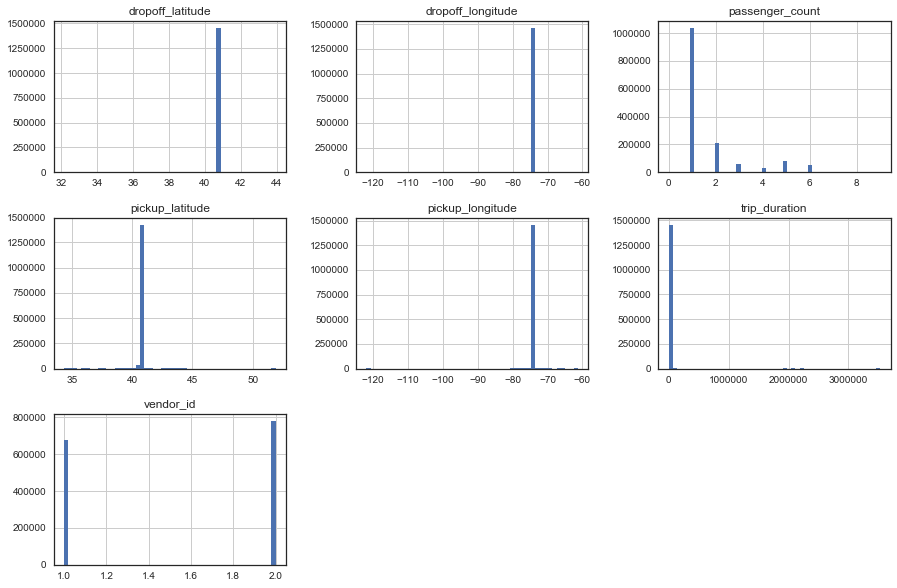

In [208]:
# Plot histograms of all the dataset features with the total number of rows
train.hist(bins=50, figsize=(15,10))
plt.show()

### Note
In the above code, we use the describe function to get a bunch of different numerical attributes of the data. From this, we can see that most of the features have pretty normal results, except for the most important feature, trip_duration. The trip_duration feature has a **huge** range between it's min and max values: 1 second vs 3526282 seconds, which is about 979.5 hours. Neither of these values seem like normal taxi trip durations, so we will need to do a bit more investigating here and possibly cap the data off at specific values to make sure it's as accurate as possible.

## Plotting the geographical data
When plotting the pickup latitude and longitudes onto a map, you can see that there are also some big outliers there as well. We can reduce the size of the plot to get a better look at the density of the pickups.

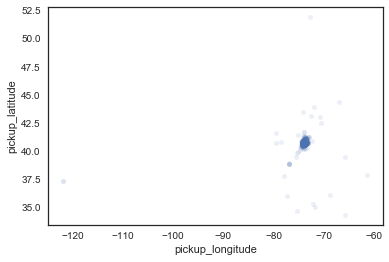

In [209]:
#Plotting the pickup latitude and longitude onto a scatterplot map
train.plot(kind="scatter", x="pickup_longitude", y="pickup_latitude", alpha=0.1)

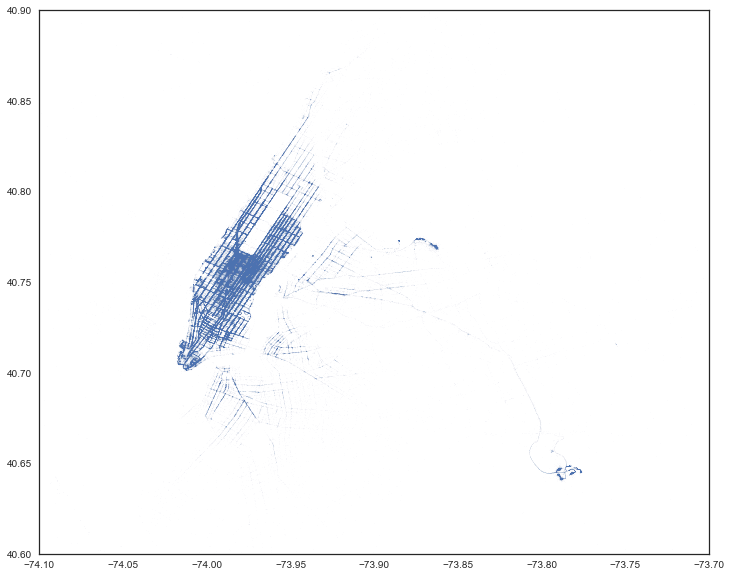

In [210]:
# Restricting the size of the graph so we can see the city more clearly
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
plt.ylim(40.6, 40.9)
plt.xlim(-74.1,-73.7)
ax.scatter(train['pickup_longitude'],train['pickup_latitude'], s=0.0002, alpha=1)

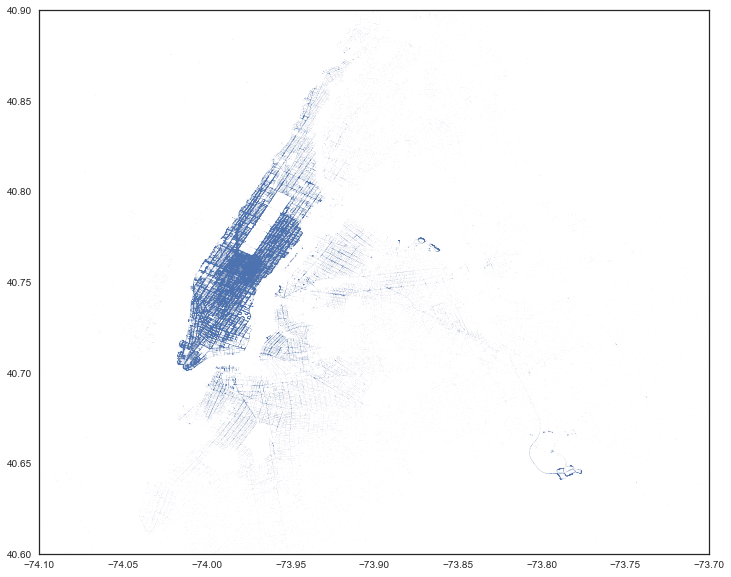

In [211]:
# Plotting the dropoff locations
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
plt.ylim(40.6, 40.9)
plt.xlim(-74.1,-73.7)
ax.scatter(traincsv['dropoff_longitude'],traincsv['dropoff_latitude'], s=0.0002, alpha=1)

### Note
On the map above, it's obvious that most of the pickups are concentrated right in NYC, but with some faint lines going pretty far away. Below, we will check the boundaries of NYC, and potentially remove any rows that go outside of the city limits. 

# 4. Prepare data

Now that we know a little bit more about the dataset, it's time to clean it and prepare it for our model. In this stage of the project, we'll also be making some more visualizations of the data. To keep our training data clean, we're going to use the copy made at the beginning of the notebook called "taxis".

## Checking for missing values
We are fortunate with this dataset that there are actually no missing values, as this means we don't have to do any transformations on the dataset to fill in the missing data.

In [212]:
# Checks to see if any values in the train and test set are null
train.isnull().values.any()

False

## Reducing outliers

In order to get a more accurate idea of the data, we're going to remove the outliers from the data. From the histogram of all the data, it's clear that there are hardly any durations that are over 500,000. Below, I've made another histogram but capped the width to see a better distribution in the data. I also took a look of the value counts for the trip_duration.

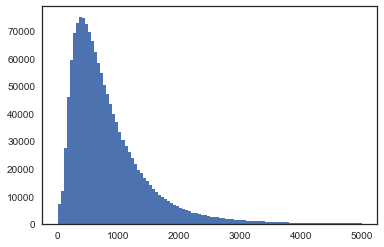

In [213]:
# Plot histogram of the trip_duration with the width capped at 5000
plt.hist(train['trip_duration'].values, bins=100, range=(0,5000))
plt.show()

In [214]:
# Looking at the value counts for trip_duration
train['trip_duration'].value_counts()

368      1624
408      1584
348      1582
367      1581
358      1577
399      1573
418      1570
417      1568
388      1567
344      1561
327      1560
449      1560
334      1556
369      1556
378      1550
422      1550
352      1549
438      1547
424      1547
357      1542
403      1540
362      1540
376      1539
353      1539
354      1538
386      1538
332      1538
398      1536
448      1536
375      1533
         ... 
85932       1
83236       1
5390        1
13184       1
6896        1
83235       1
29576       1
4361        1
5872        1
6020        1
7044        1
4999        1
85933       1
6753        1
85304       1
7440        1
6416        1
81205       1
7441        1
86328       1
82860       1
6418        1
4370        1
6022        1
5873        1
85305       1
83256       1
83884       1
6419        1
8522        1
Name: trip_duration, Length: 7417, dtype: int64

### Method for removing the outliers in trip_duration
There are 2 ways I considered removing the outliers. The first was just to cap the trip_duration at 5000, and remove all rows with a higher duration. This was very simple, but maybe not the most accurate because it was just a guess of where I should cut off the outliers. The second method is to calculate the mean and standard deviations of the trip_duration, and then make a new dataframe with data that is within 2 standard deviations of the mean. This way, my data has a smaller std, and I will still include some of the higher trip_durations. Additionally, there were also some trip_durations of 0 seconds, so this will also remove those from my new dataframe.

In [215]:
# First method
train2 = train[train['trip_duration'] <= 5000]  

In [216]:
# Second method
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

In [217]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1456540.000,1456540.000,1456540.000,1456540.000,1456540.000,1456540.000,1456540.000
mean,1.534,1.664,-73.973,40.751,-73.973,40.752,836.858
std,0.499,1.314,0.071,0.033,0.071,0.036,658.930
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1073.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,11411.000


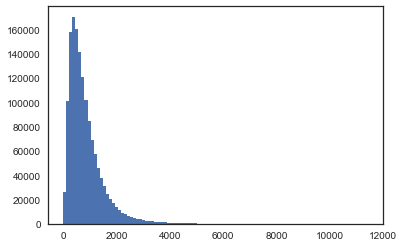

In [218]:
# Plot histograms of all the dataset features with the total number of rows
plt.hist(train['trip_duration'].values, bins=100)
plt.show()

### Reducing outliers in latitute & longitute
According to KarelVerhoevenNYCT's project: [*from A to Z with XGBoost (Tutorial)*](https://www.kaggle.com/karelrv/nyct-from-a-to-z-with-xgboost-tutorial), the coordinates of the boundaries of New York City are as follows: 

* city_long_border = (-74.03, -73.75)
* city_lat_border = (40.63, 40.85)

Therfore, to remove any data from trips outside this boundary, I'm ensuring that the data in the pickup and dropoff latitude and longitude features is within the range.

In [219]:
# Remove data that isn't within border of NYC
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

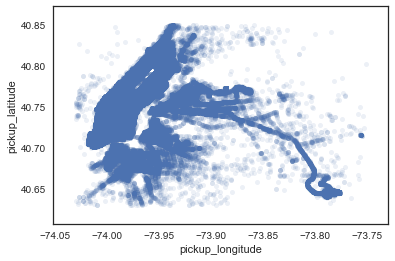

In [220]:
#Plotting the pickup latitude and longitude onto a scatterplot map with alpha low to show density
train.plot(kind="scatter", x="pickup_longitude", y="pickup_latitude", alpha=0.1)

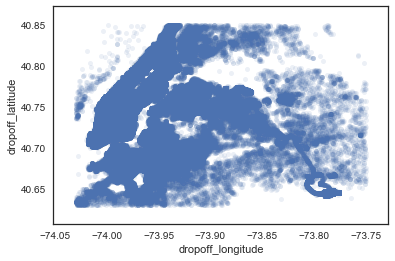

In [221]:
#Plotting the dropoff latitude and longitude onto a scatterplot map with alpha low to show density
train.plot(kind="scatter", x="dropoff_longitude", y="dropoff_latitude", alpha=0.1)

Now that we've removed the outliers, our scatterplot map is much better than it was initially! We can see that trips are picked up in NYC and outside of the city center, but the dropoff locations are more constrained in the city centre and airport. 

Something interesting we can see from the map above, is that a large amount of the trips are going from an area that is outside of NYC. When comparing this to a map, you can see that this is the main airport for NYC, John F. Kennedy. 
![](jfk.png)
*Picture of map from [Google Maps](https://www.google.no/maps?biw=1280&bih=690&q=jfk+airport+on+map&um=1&ie=UTF-8&sa=X&ved=0ahUKEwii2u_68r_eAhWCCCwKHSV7ANkQ_AUICigB)

In [222]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1437128 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1437128 non-null object
vendor_id             1437128 non-null int64
pickup_datetime       1437128 non-null object
dropoff_datetime      1437128 non-null object
passenger_count       1437128 non-null int64
pickup_longitude      1437128 non-null float64
pickup_latitude       1437128 non-null float64
dropoff_longitude     1437128 non-null float64
dropoff_latitude      1437128 non-null float64
store_and_fwd_flag    1437128 non-null object
trip_duration         1437128 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 131.6+ MB


### Removing outliers in passenger_count
When looking at the value counts of passenger_count, there are 52 rows in the dataset that have 0 passengers. We will drop these rows from the dataset.

In [223]:
# Looking at the value counts for trip_duration
train['passenger_count'].value_counts()

1    1018715
2     206864
5      76912
3      58989
6      47639
4      27957
0         52
Name: passenger_count, dtype: int64

In [224]:
# Removing rows where passenger_count is 0
train = train[train['passenger_count'] != 0]  

In [225]:
# Updated counts of the passenger_count
train['passenger_count'].value_counts()

1    1018715
2     206864
5      76912
3      58989
6      47639
4      27957
Name: passenger_count, dtype: int64

## Creating new attributes

### Creating new attributes for date and time
The original dataset includes the pickup and dropoff datetime information, but it is more useful for exploring and working with the data if we split this up into sepearate columns of time of the day, day of the week, and month.

In [226]:
# Converting the datetime features to a proper datetime format so we can work with them
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)

#Add new features for the pickup and dropoff date
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
train.loc[:, 'dropoff_date'] = train['dropoff_datetime'].dt.date

# Add new features to the training set for the pickup and dropoff day of the week
# Monday = 0, Sunday = 6
train['pickup_day'] = train['pickup_datetime'].dt.dayofweek
train['dropoff_day'] = train['dropoff_datetime'].dt.dayofweek

# Add new features to the training set for the pickup and dropoff day of the week
# January = 0
train['pickup_month'] = train['pickup_datetime'].dt.month
train['dropoff_month'] = train['dropoff_datetime'].dt.month

In [227]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1437076 entries, 0 to 1458643
Data columns (total 17 columns):
id                    1437076 non-null object
vendor_id             1437076 non-null int64
pickup_datetime       1437076 non-null datetime64[ns]
dropoff_datetime      1437076 non-null datetime64[ns]
passenger_count       1437076 non-null int64
pickup_longitude      1437076 non-null float64
pickup_latitude       1437076 non-null float64
dropoff_longitude     1437076 non-null float64
dropoff_latitude      1437076 non-null float64
store_and_fwd_flag    1437076 non-null object
trip_duration         1437076 non-null int64
pickup_date           1437076 non-null object
dropoff_date          1437076 non-null object
pickup_day            1437076 non-null int64
dropoff_day           1437076 non-null int64
pickup_month          1437076 non-null int64
dropoff_month         1437076 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(7), object(4)
memory usage: 197.4+ MB


In [228]:
# Convert the pickup and dropoff dates to datetime64
train['pickup_date'] =  pd.to_datetime(train['pickup_date'])
train['dropoff_date'] =  pd.to_datetime(train['dropoff_date'])

In [229]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1437076 entries, 0 to 1458643
Data columns (total 17 columns):
id                    1437076 non-null object
vendor_id             1437076 non-null int64
pickup_datetime       1437076 non-null datetime64[ns]
dropoff_datetime      1437076 non-null datetime64[ns]
passenger_count       1437076 non-null int64
pickup_longitude      1437076 non-null float64
pickup_latitude       1437076 non-null float64
dropoff_longitude     1437076 non-null float64
dropoff_latitude      1437076 non-null float64
store_and_fwd_flag    1437076 non-null object
trip_duration         1437076 non-null int64
pickup_date           1437076 non-null datetime64[ns]
dropoff_date          1437076 non-null datetime64[ns]
pickup_day            1437076 non-null int64
dropoff_day           1437076 non-null int64
pickup_month          1437076 non-null int64
dropoff_month         1437076 non-null int64
dtypes: datetime64[ns](4), float64(4), int64(7), object(2)
memory usage: 197

In [230]:
# Looking at our newly made columns
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,dropoff_date,pickup_day,dropoff_day,pickup_month,dropoff_month
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,2016-03-14,2016-03-14,0,0,3,3
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,2016-06-12,2016-06-12,6,6,6,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,2016-01-19,2016-01-19,1,1,1,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,2016-04-06,2016-04-06,2,2,4,4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,2016-03-26,2016-03-26,5,5,3,3


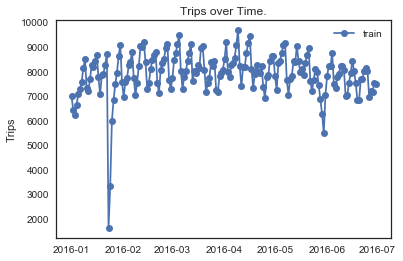

In [231]:
# Plotting the number of trips over time
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.title('Trips over Time.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

### Note
In the above plot, we can see that there was a huge drop in the number of pickups at the end of January in 2016. After doing a little research, I've concluded that this is most likely due to the [biggest snowstorm to ever happen in NYC](https://www.nbcnewyork.com/news/local/NYC-New-York-City-Blizzard-Biggest-Ever-January-23-2016-377435221.html), which basically shut down the whole city from January 21st to 29th in 2016.

There was also a smaller drop in the number of pickups in June of 2016. These drops in the number of trips shouldn't affect my accuracy, but it's something I can consider removing when I'm training my models.

### Creating new attribute for distance
Another important feature I can add to the dataset is the distance travelled for each trip. In order to calculate this, I am using a function that uses the python math function **radians**. The function was inspired by a function given on [stackoverflow](https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude) by Michael0x2a.

In [232]:
# Function for calculating distance between 2 points in km
import math

# Takes the origin and desination as parameters
def calc_distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # approximate radius of earth in km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    
    # Return approximate distance in km
    return d

In [233]:
# Testing out the function
print(calc_distance((40.768, -73.982), (40.766, -73.965)))

1.4488389564906572


In [234]:
# Function that calculates the distance of a trip (in kilometers), given a row in the dataset
def distance (row):
   return calc_distance((row['pickup_latitude'], row['pickup_longitude']), (row['dropoff_latitude'], row['dropoff_longitude']))
                           

In [235]:
# Create a new columm called distance, of distances for each trip in each row
train['distance'] = train.apply (lambda row: distance (row),axis=1)

## Visualizations of cleaned data

### Histograms
Now that we have cleaned up our data and added some more attributes, I'm making the same histograms I did at the beginning, but this time we have much better results. In these histograms we can actually see distributions of the data. From these histograms we can see that:
* The different days of the week that passengers were picked up/dropped off is fairly equal, with the most popular day being Friday.
* The most frequent passenger count is 1 passenger
* There isn't too much difference between the frequency of the different vendors, but vendor id 2 had more trips than vendor id 1

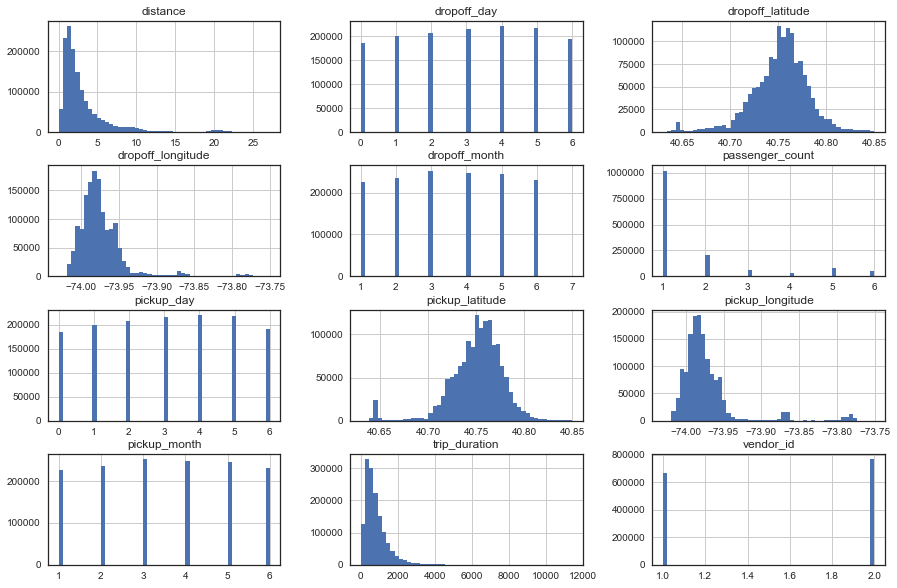

In [237]:
# Plot histograms of all the dataset features with the total number of rows
train.hist(bins=50, figsize=(15,10))
plt.show()

### Scatterplot matrix
The scatterplot matrix is a great visualization, because it can show correlations between attributes in the data. Since we have some data that doesn't work with this very well, like the latitudes and longitudes, the passenger count, and the pickup days, we don't get that much out of the scatterplot matrix (the correlation matrix and heatmap was a better way of lookig at this). However, we can still see the strong correlation between trip_duration and distance and pickup_latitude.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13ada8f60>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1210314a8>]], dtype=object)

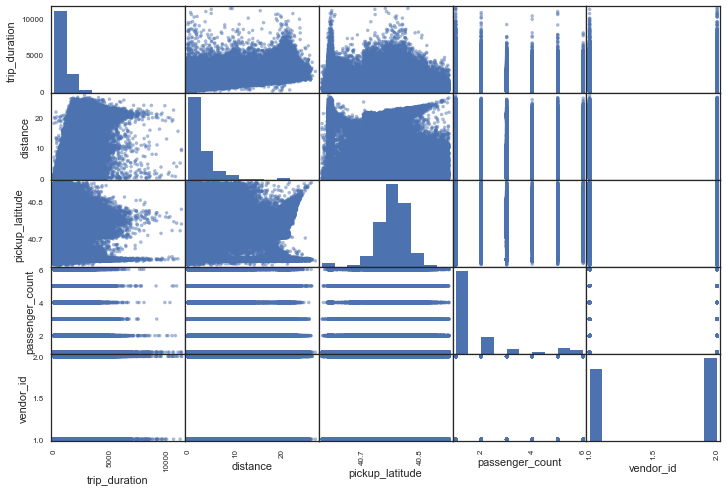

In [238]:
# Create a scatterplot of some of the attributes against each other
from pandas.plotting import scatter_matrix
attributes = ["trip_duration", "distance", "pickup_latitude", "passenger_count", "vendor_id"]
scatter_matrix(train[attributes], figsize=(12, 8))

### Correlation Matrix
One of the most useful and insightful functions in pandas is **.corr()**, which computes pairwise correlations of the columns in our dataset. Looking specifically at which columns are strongly correlated to the trip_duration, we get a nice list of the attributes and their correlations. 

Additionally, we can make a correlation matrix heatmap, which shows the same findings but in a more visual way. The more red the blocks in the matrix are, the stronger the positive correlation is, and the more blue they are, the stronger the negative correlation.

Between these two data explorations, we can see that there are a few strong positive correlations:
* Between duration and distance
* Between duration and pickup location
* Between passenger count and vendor id

In [239]:
# Looking at the standard correlation efficient between each of the attributes
corr_matrix = train.corr()
corr_matrix["trip_duration"].sort_values(ascending=False)

trip_duration        1.000
distance             0.769
pickup_longitude     0.363
dropoff_longitude    0.255
dropoff_month        0.060
pickup_month         0.059
passenger_count      0.015
vendor_id            0.008
dropoff_day         -0.034
pickup_day          -0.035
dropoff_latitude    -0.197
pickup_latitude     -0.235
Name: trip_duration, dtype: float64

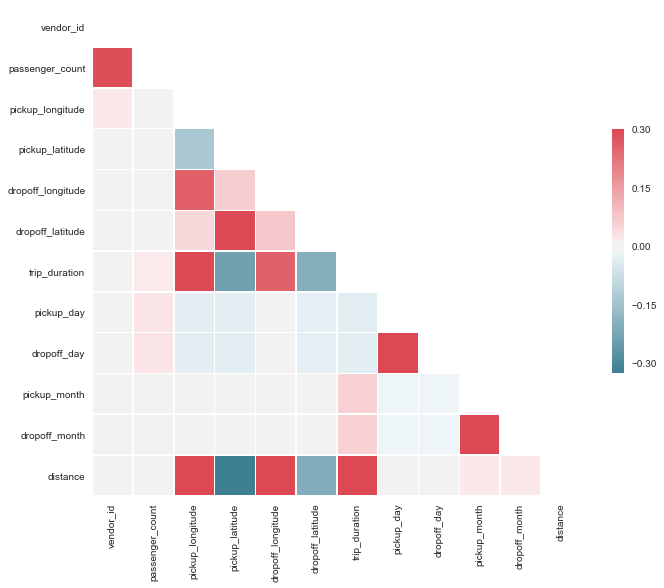

In [240]:
# Create a correlation matrix heat map
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
from string import ascii_letters
import seaborn as sns

sns.set(style="white")

# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Dropping attributes
Finally, I'm going to remove a few attributes from the dataset we know longer need: 
* pickup_datetime and dropoff_time have been split into new columns for date and time, etc.
* store_and_fwd flag doesn't contribute to the trip_duration

In [241]:
train = train.drop(['pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag'], axis=1)

In [242]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1437076 entries, 0 to 1458643
Data columns (total 15 columns):
id                   1437076 non-null object
vendor_id            1437076 non-null int64
passenger_count      1437076 non-null int64
pickup_longitude     1437076 non-null float64
pickup_latitude      1437076 non-null float64
dropoff_longitude    1437076 non-null float64
dropoff_latitude     1437076 non-null float64
trip_duration        1437076 non-null int64
pickup_date          1437076 non-null datetime64[ns]
dropoff_date         1437076 non-null datetime64[ns]
pickup_day           1437076 non-null int64
dropoff_day          1437076 non-null int64
pickup_month         1437076 non-null int64
dropoff_month        1437076 non-null int64
distance             1437076 non-null float64
dtypes: datetime64[ns](2), float64(5), int64(7), object(1)
memory usage: 175.4+ MB


## Remarks on preprocessing
Now that I have finished preprocessing my data, it's time to actually train it using multiple models and try to get a high accuracy score. After preprocessing, I'm left with the following columns:
* id
* vendor_id
* passenger_count
* pickup_longitude
* pickup_latitude
* dropoff_longitude
* dropoff_latitude
* trip_duration  
* pickup_date & dropoff_date
* pickup_day & dropoff_day (day of the week)
* pickup_month & dropoff_month
* distace (in km)

I started with 11 columns and 1458644 rows, all of numerical data. I now have 16 columns and 1437128 rows. I was fortunate that I had no missing values, however, I did many outliers. 

# 5. Explore Models
These are the models I'm going to try out on my cleaned data:

* Linear Regression
* Decision Tree
* K-Nearest Neighbour Regression
* Random Forest Regressor
* Gradient Boosting Regressor
* AdaBoost
* XGBoost

All the models I tried were outlined on Scikit Learn's list of regression models for supervised learning.

The process for fitting the model to the training data is pretty much the same for all 6 algorithms:

1. Import the algorithm from sklearn
2. Make an instance of the algorithm class, ie: lin_reg = LinearRegression()
3. Fit the model on the training date: lin_reg.fit(X_train, y_train)
Additionally, the process for making predicitons on the training data and getting scores is also pretty much the same, as outlined here:

1. Making predictions on the data using the algorithms predict function
2. Caluclate the mean squared error between the predictions and the actual values
3. And, to get a more accurate score, calculate the score using cross validation

In [243]:
# Make another copy of the training set, this time without the output values
taxis_prepared = train.drop("trip_duration", axis=1)
taxis_labels = train["trip_duration"].copy()
taxis_lin = train.drop(['id', 'pickup_date', 'dropoff_date'], axis=1)

In [244]:
# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(taxis_prepared, taxis_labels, test_size=0.33, random_state=42)

## Linear Regression
Linear Regression tries to find a linear model that best fits the data. 

When training the linear regression model, it actually predicted the same values as the labels, which indicates that the model is overfitting on the dataset. However, when calculating the root mean squared error of the predictions, it was quie high compared to the other models. Linear Regression is a fairly simple model, so we will probably go with something a bit more intricate.

In [ ]:
# import model and fit to the dataset
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(taxis_lin, taxis_labels)

In [18]:
# Get some random values to predict
some_data = taxis_lin.iloc[:10]
some_labels = taxis_labels.iloc[:10]

In [19]:
# Print the predictions
print("Predictions:\t", lin_reg.predict(some_data))

Predictions:	 [  455.   663.  2124.   429.   435.   443.   341.  1551.   255.  1225.]


In [20]:
print("Labels:\t\t", list(some_labels))

Labels:		 [455, 663, 2124, 429, 435, 443, 341, 1551, 255, 1225]


In [21]:
# Import the mean_squared_error to calculate the error of the model
from sklearn.metrics import mean_squared_error
taxis_prediction = lin_reg.predict(taxis_lin)

In [22]:
# Calculate the root mean squared error of the model
# The result is how many seconds away from the value we are on average
lin_mse = mean_squared_error(taxis_labels, taxis_prediction)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

8.1417069572592598e-12

## Decision Tree
The Decision Tree Model makes its predictions by learning simple decision rules from the data features. For example, "If distance > 10 AND pickup_longitude = 40.71, trip_duration = 300. 

The decision tree had a low mean and standard deviation, but it had a root mean squared error of 0... this is indicating that the decision tree model is overfitting on the data.

In [23]:
# Import model and fit to data
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(taxis_lin, taxis_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf='deprecated',
           min_samples_split=2, min_weight_fraction_leaf='deprecated',
           presort=False, random_state=None, splitter='best')

In [24]:
# Calculate root mean squared error
taxis_pred = tree_reg.predict(taxis_lin)
tree_mse = mean_squared_error(taxis_labels, taxis_pred)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [25]:
# Calculate the cross validation score + print them
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, taxis_lin, taxis_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [27]:
# Create method to display scores
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())

In [27]:
# Show mean dn standard deviation
display_scores(tree_rmse_scores)

Scores:  [ 0.85233801  1.06827103  1.50526534  2.09039964  0.21537346  0.74296789
  0.43333348  1.3270293   0.46217019  0.39057202]
Mean:  0.908772036452
Standard Deviation:  0.561954696634


## K-Nearest Regressor

In [50]:
from sklearn.neighbors import KNeighborsRegressor

In [60]:
kn_reg = KNeighborsRegressor()
kn_reg.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

In [61]:
knr_pred = kn_reg.predict(X_test)
knr_mse = mean_squared_error(y_test, knr_pred)
knr_rmse = np.sqrt(knr_mse)
knr_rmse

0.60967612212949474

In [62]:
scores = cross_val_score(kn_reg, X_test, y_test, scoring="neg_mean_squared_error", cv=10)
knr_rmse_scores = np.sqrt(-scores)
display_scores(knr_rmse_scores)

Scores:  [ 0.5620663   1.22108355  0.60209794  0.45997253  3.00074918  0.42390309
  0.89917454  0.99317877  0.64139382  0.57733663]
Mean:  0.938095634825
Standard Deviation:  0.728329458958


## Random Forest Regressor

In [63]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

/Users/lauramann/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf='deprecated', min_samples_split=2,
           min_weight_fraction_leaf='deprecated', n_estimators=10,
           n_jobs=None, oob_score=False, random_state=None, verbose=0,
           warm_start=False)

In [64]:
rfr_pred = rfr.predict(X_test)
rfr_mse = mean_squared_error(y_test, rfr_pred)
rfr_rmse = np.sqrt(rfr_mse)
rfr_rmse

0.90044407856698028

In [65]:
scores = cross_val_score(rfr, X_test, y_test, scoring="neg_mean_squared_error", cv=10)
rfr_rmse_scores = np.sqrt(-scores)
display_scores(rfr_rmse_scores)

Scores:  [ 1.04024451  1.98902639  0.64886147  0.4212304   3.48609741  0.4951332
  4.0919602   1.66606473  0.58914239  1.3763142 ]
Mean:  1.58040748893
Standard Deviation:  1.21734071018


## Gradient Boosting Regressor

In [66]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf='deprecated',
             min_samples_split=2, min_weight_fraction_leaf='deprecated',
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [68]:
taxis_pred = gbr.predict(X_test)
gbr_mse = mean_squared_error(y_test, taxis_pred)
gbr_rmse = np.sqrt(gbr_mse)
gbr_rmse

6.7625996225461007

In [119]:
scores = cross_val_score(gbr, X_test, y_test, scoring="neg_mean_squared_error", cv=10)
gbr_rmse_scores = np.sqrt(-scores)
display_scores(gbr_rmse_scores)

Scores:  [ 6.73091277  6.82144819  6.79147548  6.72688264  7.48346483  6.78105666
  6.95474063  6.7858994   6.76375353  6.7831382 ]
Mean:  6.8622772317
Standard Deviation:  0.215659916606


## Ada Boost Regressor

In [70]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [71]:
abr = AdaBoostRegressor()

In [72]:
abr.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None)

In [73]:
taxis_pred = abr.predict(X_test)
abr_mse = mean_squared_error(y_test, taxis_pred)
abr_rmse = np.sqrt(abr_mse)
abr_rmse

112.07076611698773

In [28]:
scores = cross_val_score(abr, X_test, y_test, scoring="neg_mean_squared_error", cv=10)
abr_rmse_scores = np.sqrt(-scores)
display_scores(abr_rmse_scores)

Scores:  [ 105.36138347  114.60543557  122.15001071  100.87328724  109.29397376
  102.07223726  115.18185352  103.74860411  102.99535905  111.37682471]
Mean:  108.76589694
Standard Deviation:  6.62311433672


## XGBoost Regressor

In [120]:
import xgboost
xgb = xgboost.XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [31]:
xgb.score(X_test, y_test)

0.99988698292628619

In [41]:
y_pred = xgb.predict(X_test)

In [43]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred)

4.4883685176591861

In [45]:
xgb_mse = mean_squared_error(y_test, y_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse

6.8002838054878403

In [47]:
scores = cross_val_score(xgb, X_test, y_test, scoring="neg_mean_squared_error", cv=10)
xgb_rmse_scores = np.sqrt(-scores)
display_scores(xgb_rmse_scores)

Scores:  [ 6.80981977  6.95008201  6.98770085  6.86616707  7.45939684  6.86440379
  7.08551306  6.79484173  6.88030799  6.88628378]
Mean:  6.95845168841
Standard Deviation:  0.185890281862


## Best Models... so far
Right now, the best models (without any parameter tuning) are:

**1. K Nearest Regressor**
Mean: 0.94
STD: 0.73

**2. Random Forest Regressor**
Mean: 1.58
STD: 1.21

**3. Decision Tree**
Mean: 0.91
STD: 0.56

**4. Gradient Boosting Regressor **
Mean: 6.86
STD: 0.22

**5. XGBoost**
Mean: 6.96
STD: 0.19

The top two models are very close, but the XGBoost model has the lowest standard deviation of all the models. In the next section, I will be focusing on fine-tuning the parameters of the **K-Nearest Regressor**, **Random Forest Regressor**, and **XGBoost Regressor**.

# 6. Fine-Tune
Now that we've looked at multiple models and have a couple chosen with promising results, we can tune the parameters of the best ones and try to reduce the error

## Grid Search
The Grid Search exhaustively generates candidates from a grid of parameter values specified with the param_grid parameter, fits each model on the dataset, trying all the possible combinations of parameter values. The best combination is retained.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [114]:
# Reducing the size of my training set due to system limitation...
X_train2 = X_train.iloc[:20000]
y_train2 = y_train.iloc[:20000]
X_test2 = X_test.iloc[:20000]
y_test2 = y_test.iloc[:20000]

### 1. K-Nearest Regressor

In [48]:
param_grid_2 = [
    {'n_neighbors': [2, 8, 12, 16], 'leaf_size': [25, 30, 40]},
    {'n_neighbors': [2, 8, 12], 'leaf_size': [25, 30, 40, 50]},
]

In [115]:
kn_reg = KNeighborsRegressor()
grid_search_knr = GridSearchCV(kn_reg, param_grid_2, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

In [117]:
grid_search_knr.fit(X_test2, y_test2)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_neighbors': [2, 8, 12, 16], 'leaf_size': [25, 30, 40]}, {'n_neighbors': [2, 8, 12], 'leaf_size': [25, 30, 40, 50]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [55]:
grid_search_knr.best_params_

{'leaf_size': 25, 'n_neighbors': 2}

In [56]:
best_knr = grid_search_knr.best_estimator_

In [57]:
best_knr.fit(X_test, y_test)

KNeighborsRegressor(algorithm='auto', leaf_size=25, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform')

In [58]:
best_knr_pred = best_knr.predict(X_test)
best_knr_mse = mean_squared_error(y_test, best_knr_pred)
best_knr_rmse = np.sqrt(best_knr_mse)
best_knr_rmse

0.54290482965482478

In [59]:
scores = cross_val_score(best_knr, X_test, y_test, scoring="neg_mean_squared_error", cv=10)
best_knr_rmse_scores = np.sqrt(-scores)
display_scores(best_knr_rmse_scores)

Scores:  [ 0.66426112  1.10396533  0.57722243  0.50465946  2.46706545  0.50365566
  0.71492887  0.58723353  0.5951386   0.5075189 ]
Mean:  0.822564936084
Standard Deviation:  0.573544359525


### 2. Random Forest Regressor

In [79]:
forest_param_grid = [
    {'n_estimators': [60, 100, 150], 'max_features': [5, 8, 10, 12]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, forest_param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train2, y_train2)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf='deprecated', min_samples_split=2,
           min_weight_fraction_leaf='deprecated', n_estimators='warn',
           n_jobs=None, oob_score=False, random_state=42, verbose=0,
           warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [60, 100, 150], 'max_features': [5, 8, 10, 12]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [80]:
grid_search.best_params_

{'max_features': 12, 'n_estimators': 100}

In [81]:
best_rfr = grid_search.best_estimator_

In [82]:
best_rfr.fit(X_test2, y_test2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=12, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf='deprecated',
           min_samples_split=2, min_weight_fraction_leaf='deprecated',
           n_estimators=100, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [84]:
best_rfr_pred = best_rfr.predict(X_test)
best_rfr_mse = mean_squared_error(y_test, best_rfr_pred)
best_rfr_rmse = np.sqrt(best_rfr_mse)
best_rfr_rmse

0.52843464583345512

In [118]:
scores = cross_val_score(best_rfr, X_test2, y_test2, scoring="neg_mean_squared_error", cv=10)
best_rfr_rmse_scores = np.sqrt(-scores)
display_scores(best_rfr_rmse_scores)

Scores:  [ 27.83288514  14.26216054   2.33590953  19.46925468   3.30266614
   1.01683558   3.01933017   1.70969582   1.89385176   8.00906256]
Mean:  8.28516519268
Standard Deviation:  8.76276313214


### 3. XGBoost

In [95]:
param_grid_xgb = [
    {'n_estimators': [180, 200, 220, 240]},
]

xgb_reg = xgboost.XGBRegressor()
grid_search_xgb = GridSearchCV(xgb_reg, param_grid_xgb, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

In [96]:
grid_search_xgb.fit(X_test2, y_test2)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [120, 140, 160, 180]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [101]:
grid_search_xgb.best_params_

{'n_estimators': 180}

In [108]:
best_xgb = grid_search_xgb.best_estimator_

In [109]:
best_xgb.fit(X_test, y_test)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=180,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [110]:
best_xgb_pred = best_xgb.predict(X_test)
best_xgb_mse = mean_squared_error(y_test, best_xgb_pred)
best_xgb_rmse = np.sqrt(best_xgb_mse)
best_xgb_rmse

5.7709500436673133

In [111]:
scores = cross_val_score(best_xgb, X_test, y_test, scoring="neg_mean_squared_error", cv=10)
best_xgb_rmse_scores = np.sqrt(-scores)
display_scores(best_xgb_rmse_scores)

Scores:  [ 5.81287777  5.83079903  5.94030225  5.81927153  6.32494616  5.80036537
  5.94104691  5.81992812  5.7974714   5.87810843]
Mean:  5.89651169717
Standard Deviation:  0.151655115772


# 7. Presenting the Solution
And the winner is... **Random Forest Regression!** (Altough the result was super close to K-Nearest Regressor)

## What I Learned
In regards to the data I was investigating, I learned that the average length of a taxi trip in New York City is about 13.94 minutes, and that the average distance of a trip is around 2 km. While this seems unusually long for such a short distance, upon investigation of the normal speeds in NYC, it appears that as of Januaray 2018, the [average driving speed in downtown Manhattan is around 7.5 km per hour](http://www.latimes.com/nation/la-na-new-york-traffic-manhattan-20180124-story.html)... 

Other than that, this dataset actually proved to have pretty obvious results. There were no huge discoveries made here, as the trip_duration was very closely related to the trip_distance. Especially when the outliers were removed, I was able to predict trip_duration with fairly high accuracy.

Compared to the first assignment, this project consisted of more independent research and work, as I wasn't just following along with the chapter in the book. Aside from some of the kernels on Kaggle that were helpful, I didn't have a working solution to check back to and make sure I was on the right track, so I learned so much about preprocessing and training! In the preprocessing stage, I learned HOW important it is to clean your data before training it. I spent a long time examining the initial histograms of the data and wondering why they were all vertical lines, until I realized that it was just a few HUGE outliers that were skewing the whole dataset. After removing them, I was actally able to see normal distributions on the histograms, and plot the data on other types of graphs to explore it. 

In the model-training phase I learned to be patient... The first assignment had proven how long it can take to train a model and fine-tune it, but this dataset was about **70 times** larger than the housing dataset even after preprocessing.

## What Worked/ What Didn't
When preprocessing, I struggled when working with the date and time values of the dataset. I wanted to be able to look at how a specific day of the week, time of the month, or time of the day affected how long your taxi trip would take, but this proved to be more difficult than I thought. In the end, I ended up dropping the pickup_time and dropoff_time from the training and testing sets because I couldn't train the data with them included.

What ended up working really well was the Random Forest Regressor and the K-Nearest Regressor. While they both had extremely close rmse's, the Random Forest Regressor came out on top with a rmse of only 0.52, while K-Neighbours had an rmse of 0.54.

What didn't work very well at all was the AdaBoost model. While I didn't try to tune any of the parameters, it had awful scores the first time, so I decided to focus on the ones that were performing well already.

The XGBoost Regressor performed relatively well, as it had a really low standard deviation, but it's rmse was 5.77 (compared to the top 2 under 1). 

## Assumptions
I had assumed that the XGBoost Regressor would perform better. I think to improve the accuracy, I would need to explore different ways of parameter-tuning that are more specific to the XGBoost model.

## System's Limitations
I'm working on a 2012 Macbook, so it doesn't have the BEST specs, and I ended up waiting hours for some of the Grid Searches to run. Other than that, everything else ran pretty smoothly on my computer!

## Conclusion
In conclusion, my final model finished with a mean score of 0.52!

# 8. Launch, Monitor, & Maintain
In this phase of the process, I would be feeding my model updated data, and trying to train the model regualarly in order to improve the score. It would helpful to automate a lot of this, especially if the data was coming from an online source and this could be done on an online server. An interesting part in this process is the **human analysis** part, meaning that you can't just train and test a model, automate it to predict the price of a house in California given certain factors, and expect it to be good to go. These systems can still be wrong, even if they have a really low accuracy score, and it's crucial to have humans go in and check that the system is giving accurate information. In this example, if the prediction was off by 10 km, it wouldn't be too devasting, but in a case where it means life or death (like predicting whether or not someone has cancer), it's really important to have human imput.